In [14]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn

from tqdm import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [2]:
data_norm = np.genfromtxt('features_scaled.csv', delimiter=',', dtype=np.float32)

In [3]:
data_anom = np.genfromtxt('features_anom_scaled.csv', delimiter=',', dtype=np.float32)

In [21]:
np.random.shuffle(data_anom)
np.random.shuffle(data_norm)

In [22]:
data_norm_train = data_norm[:120000]
data_norm_test = data_norm[120000:148577]

data_anom_val = data_anom[:1024]
data_anom_test = data_norm[1025:12685]

In [18]:
class CAE(nn.Module):
    def __init__(self):
        super(CAE, self).__init__()
        self.encoder = nn.Sequential( # input 37x37x1
            
            # conv1
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=2), # (37-3)/2+1 = 18
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), # 18/2=9 => output is 9x9x16
            
            # conv2
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2), # (9-3)/2+1 = 4            
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # 4/2 = 2 => output is 2x2x32 = 128
            
        )
        
        # dense layers
        self.dense1 = nn.Linear(128, 64)
        self.dense2 = nn.Linear(64, 128)
        
        self.decoder = nn.Sequential(
            
            # convt1
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            
            # convt2
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=3, stride=2),
            nn.BatchNorm2d(1),
            nn.ReLU()
        
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = torch.nn.functional.relu(self.dense1(x.view(x.size(0), -1))) # flatten tensor
        x = torch.nn.functional.relu(self.dense2(x))
        x = self.decoder(x.view(x.size(0), 32, 2, 2)) # reshape tensor to 32x2x2
        return x

In [7]:
def live_plot(train, val, title=''):
    clear_output(wait=True)
    fig, ax1 = plt.subplots(dpi=120)
    ax1.plot(train, label='Training Loss', color='red')
    ax1.plot(val, label='Validation Loss', color='blue')
    ax1.legend(loc='lower left')
    ax1.set_ylabel('Reconstruction MSE Loss')
    ax1.set_xlabel('Epoch')
    plt.title(title)
    plt.show()

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_limit = 512
batch_size = 32
epoch = 10000
cae = CAE().to(device)
optimizer = torch.optim.Adam(cae.parameters(), lr=1e-3)
criterion = nn.MSELoss()
criterion_val = nn.MSELoss()
loss_list = []
val_list = []

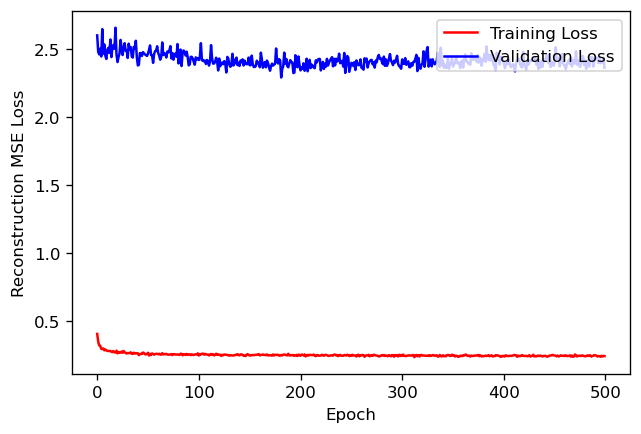

  5%|██▎                                          | 500/10000 [33:43<10:07:15,  3.84s/it]

  5%|██▎                                          | 500/10000 [33:43<10:40:51,  4.05s/it]

KeyboardInterrupt: 

In [26]:
for e in tqdm(range(epoch)):
    epoch_loss = 0

    for idx in range(batch_limit):
        optimizer.zero_grad()
        indices = np.random.randint(low=0, high=120000, size=batch_size)
        train_tensor = torch.from_numpy(np.array([data_norm_train[i] for i in indices]).reshape(batch_size, 1, 37, 37)).to(device)
        target_tensor = torch.from_numpy(np.array([data_norm_train[i] for i in indices]).reshape(batch_size, 1, 37, 37)).to(device)

        target_pred = cae(train_tensor)
        loss = criterion(target_pred, target_tensor)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"Batch loss ({idx+1}/{batch_limit}): {loss.item()}", end='\r')
        
    with torch.no_grad():
        val_tensor = torch.from_numpy(data_anom_val.reshape(1024, 1, 37, 37)).to(device)
        val_target_tensor = torch.from_numpy(data_anom_val.reshape(1024, 1, 37, 37)).to(device)
        
        val_target_pred = cae.forward(val_tensor)
        loss_val = criterion_val(val_target_pred, val_target_tensor)
        
        loss_list.append(epoch_loss/batch_limit)
        val_list.append(loss_val.item())
        
        clear_output(wait=True)
        fig, ax1 = plt.subplots(dpi=120)
        ax1.plot(np.array(loss_list), label='Training Loss', color='red')
        ax1.plot(np.array(val_list), label='Validation Loss', color='blue')
        ax1.legend(loc='upper right')
        ax1.set_ylabel('Reconstruction MSE Loss')
        ax1.set_xlabel('Epoch')
        plt.show()

In [27]:
torch.save(cae.state_dict(), 'cae.pt')